In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_2022_gex_scvi.h5ad")

In [4]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [5]:
adata

AnnData object with n_obs × n_vars = 16918 × 2000
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets', 

# PCA of GEX space

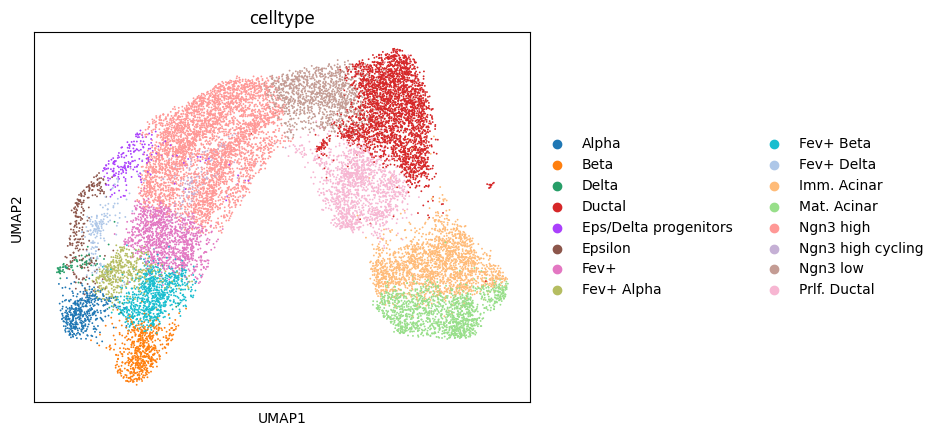

In [6]:
sc.pl.umap(adata, color="celltype")

In [7]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time")

In [8]:
tp0 = tp0.solve(epsilon=1e-2, scale_cost="mean", max_iterations=1e4)

In [9]:
tp0[14.5, 15.5].solution.converged

True

In [15]:
tm = tp0.cell_transition(start=14.5, end=15.5, early_annotation="celltype", late_annotation="celltype", forward=True)

In [11]:
import moscot.plotting as mpl

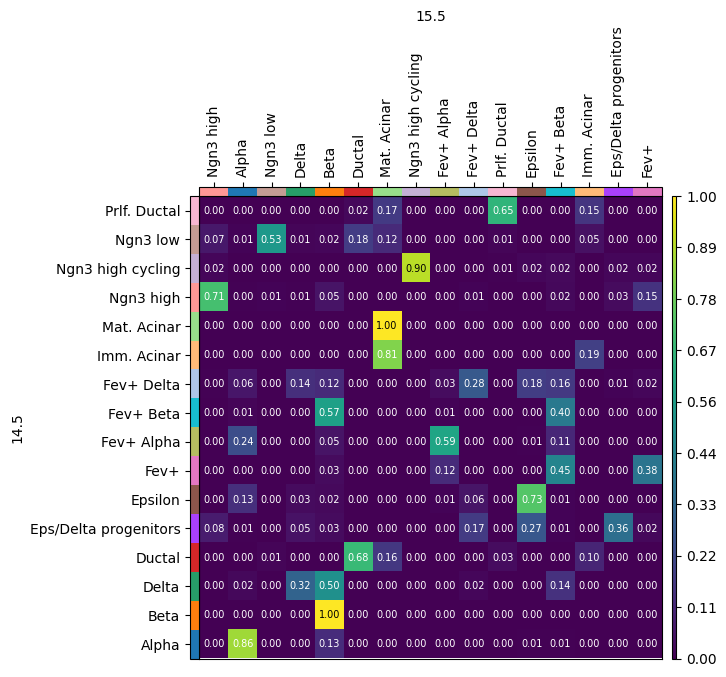

In [17]:
mpl.cell_transition(tp0, dpi=100, fontsize=7)

In [18]:
transition_matrix = tp0.cell_transition(14.5, 15.5, early_annotation="celltype", late_annotation="celltype", forward=False)

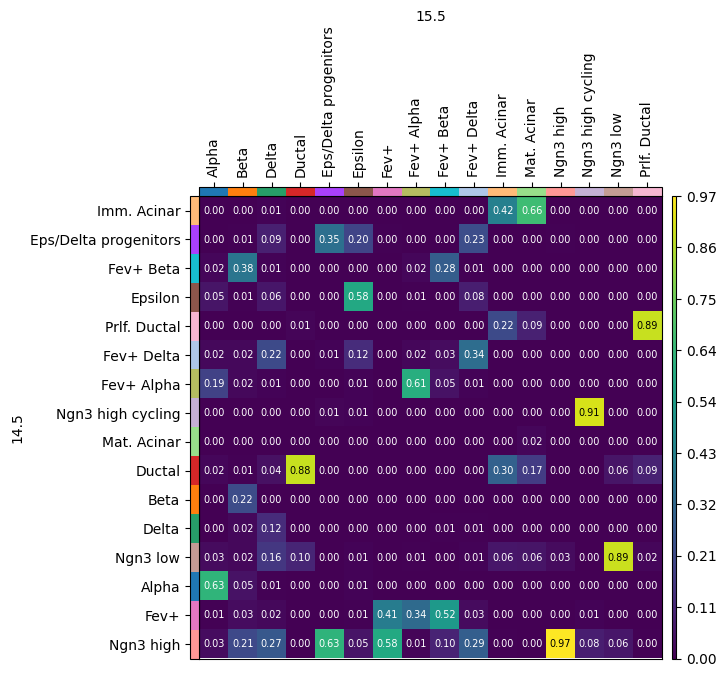

In [19]:
mpl.cell_transition(tp0, dpi=100, fontsize=7)

# scVI of GEX space

In [22]:
adata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_scVI, X_scVI_pca, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, umap, umap_ATAC, umap_GEX

In [24]:
tp1 = TemporalProblem(adata)
tp1 = tp1.prepare("time", joint_attr="X_scVI")

In [25]:
tp1 = tp1.solve(epsilon=1e-2, scale_cost="mean", max_iterations=1e4)

In [27]:
tp1[14.5, 15.5].solution.converged

True

In [28]:
tm = tp1.cell_transition(start=14.5, end=15.5, early_annotation="celltype", late_annotation="celltype", forward=True)

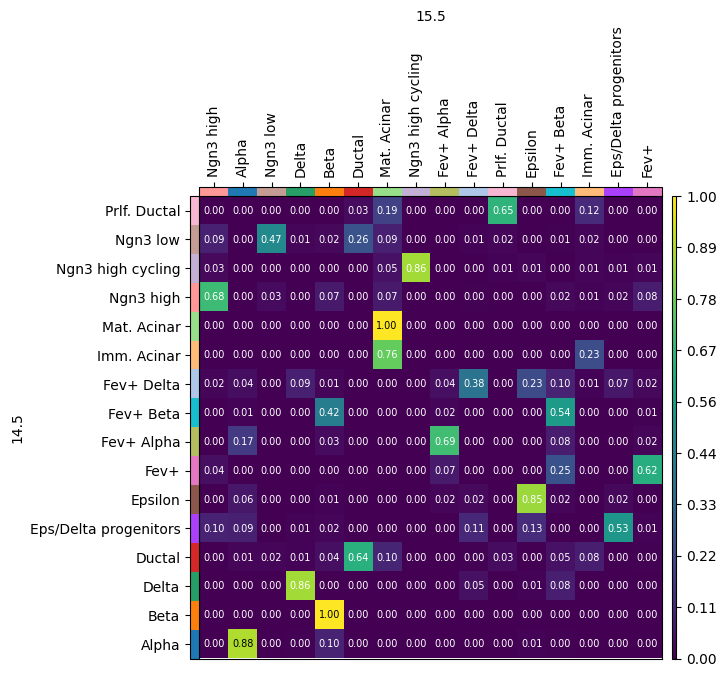

In [29]:
mpl.cell_transition(tp1, dpi=100, fontsize=7)

In [30]:
transition_matrix = tp1.cell_transition(14.5, 15.5, early_annotation="celltype", late_annotation="celltype", forward=False)

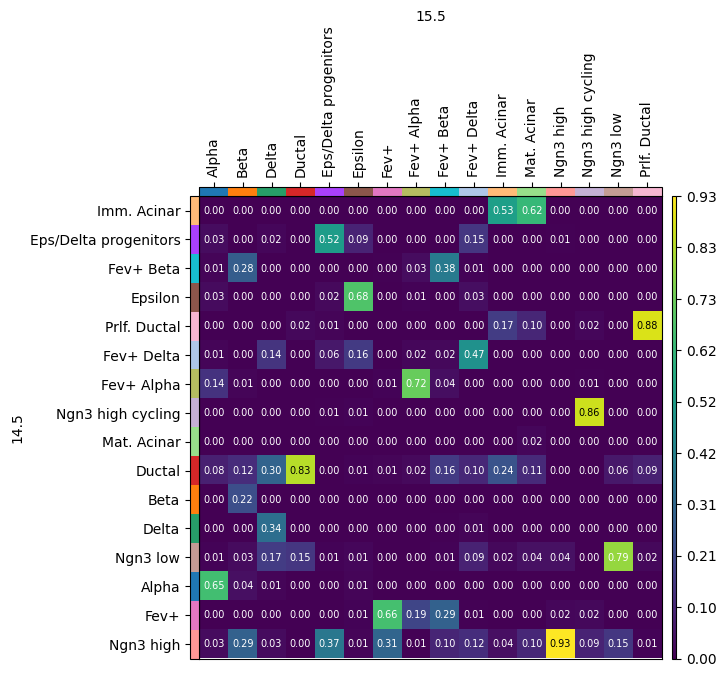

In [31]:
mpl.cell_transition(tp0, dpi=100, fontsize=7)